# Predicting Wine Taste Quality

# Scenario 3: Only Outliers on 6 Stepwise Features Removed

### This is a supplemental notebook for alternate code results, and is not a complete version of the project. For the complete version, see Wine_Taste_Quality.ipynb

Importing Modules

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from sklearn.cross_validation import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from functools import partial
%matplotlib inline

Functions

In [2]:
def predict(x_i, beta):
    return np.dot(x_i, beta)

def regr_error(x_i, y_i, beta):
    return y_i - predict(x_i, beta)

def calc_pred_vals(list_of_rows, list_of_betas, intercept=0):
    pred_vals = []
    for i in range(len(list_of_rows)):
        pred_val = intercept + predict(list_of_rows[i], list_of_betas)
        pred_vals.append(pred_val)
    return pred_vals

# rmse calculation
def calc_rmse(preds, target):
    errors, squared_error = [], []
    for i in range(len(target)):
        errors.append(target[i] - preds[i])
    for error in errors:
        squared_error.append(error**2)
    mse = sum(squared_error)/len(squared_error)
    rmse = np.sqrt(mse)
    return rmse

# convert continous values to discrete
def round_prediction(predicted_values):
    preds = []
    for i in range(len(predicted_values)):
        pred_val = predicted_values[i]
        if pred_val < 0.5: preds.append(0)
        elif pred_val >= 0.5 and pred_val < 1.5: preds.append(1)
        elif pred_val >= 1.5 and pred_val < 2.5: preds.append(2)
        elif pred_val >= 2.5 and pred_val < 3.5: preds.append(3)
        elif pred_val >= 3.5 and pred_val < 4.5: preds.append(4)
        elif pred_val >= 4.5 and pred_val < 5.5: preds.append(5)
        elif pred_val >= 5.5 and pred_val < 6.5: preds.append(6)
        elif pred_val >= 6.5 and pred_val < 7.5: preds.append(7)
        elif pred_val >= 7.5 and pred_val < 8.5: preds.append(8)
        elif pred_val >= 8.5 and pred_val < 9.5: preds.append(9)
        elif pred_val >= 9.5: preds.append(10)
        else: print 'check predicted value'
    return preds

#return a list of list of confusion matrix entries
def confusion_entries(num_rows, preds, targets):
    A = [[0 for j in range(num_rows)] for i in range(num_rows)]
    #outer loop iterates through each target and prediction 
    for i in range(len(targets)): 
        pred, target = preds[i], targets[i]
        #inner loop iterates through each cell in the confusion matrix
        for j in range(num_rows): 
            for k in range(num_rows):
                #there will be one match in each inner iteration
                if target==j and pred==k: 
                    #increment value in cell when match is found
                    A[j][k] += 1  
    return A

# create dataframe for model coefficients
def make_df(betas, attributes, ix, intercept=0):
    new_beta_list, new_columns = [], []
    new_columns.append('intercept')
    new_beta_list.append(round(intercept, 5))
    for i in range(len(betas)):
        new_columns.append(attributes[i])
        beta = betas[i]
        new_beta_list.append(round(beta, 5))
    new_df = pd.DataFrame(new_beta_list, index=new_columns, columns=ix).T
    return new_df

# return requested columns of dataset - used in stepwise algorithm
def x_features_cols(dataset, features):
    x_out = []
    for row in dataset:
        x_out.append([row[i] for i in features])
    return(x_out)

# scale a row of features' values given as input for a predicted value
# receive 3 lists (row of inputs, original means & stds for each feature)
def scale_vals(row, orig_mean, orig_std):
    scaled_row = []
    for i in range(len(row)):
        scaled_value = (row[i] - orig_mean[i]) / orig_std[i]
        scaled_row.append(scaled_value)
    return scaled_row

#used in minimization function
def in_random_order(data):    
    indexes = [i for i, _ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes: 
        yield data[i]

Functions (cont'd)

In [3]:
def model_details(name, preds, betas, intercept, feat_seq, targets, calc_acc=True):
    
    model_name = []     
    model_name.append(name) # name must be in list format; df col gets transformed to index
    modl_name.append(name) # global variable
    
    # store rms error
    rms_error = calc_rmse(preds, targets)
    rmse.append(rms_error)
    
    # store dataframe of model's beta coefficients 
    df_coeff = make_df(betas, feat_seq, model_name, intercept)
    df_beta_coefs.append(df_coeff) 
    
    # calculate accuracy & store confusion matrix, unless labels are scaled
    if calc_acc:
        actual_ix = ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']
        pred_ix = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']
        rounded_preds = round_prediction(preds)
        con_mat = confusion_entries(len(pred_ix), rounded_preds, targets)
        cmat = pd.DataFrame(con_mat, index=actual_ix, columns=pred_ix)
        #delete columns with no results, eg, taste quality: 0, 1, 2, 9 & 10 are zero
        del cmat['P0']; del cmat['P1']; del cmat['P2']; del cmat['P9']; del cmat['P10']
        cmat = cmat.ix[3:] # delete rows 0, 1 & 2
        cmat = cmat.ix[:6] # delete last 2 rows
        #add column for row total
        cmat['Total']=cmat['P3']+cmat['P4']+cmat['P5']+cmat['P6']+cmat['P7']+cmat['P8']
        #denominator should equal total number of rows in dataset)
        sum_total = cmat['Total'].sum()
        # add along diagonal for true positives (numerator) 
        tp = cmat.iloc[0]['P3']+cmat.iloc[1]['P4']+cmat.iloc[2]['P5']+cmat.iloc[3]['P6'] +\
        cmat.iloc[4]['P7'] + cmat.iloc[5]['P8']
        acc = tp / sum_total  # accuracy is true positives divided by the sum total
        cmats.append(cmat)
        cmat_sum.append(sum_total)
        accuracy.append(acc)        
    else:
        cmats.append('n/a, labels are scaled')
        cmat_sum.append('n/a, labels are scaled')
        accuracy.append('n/a, labels are scaled')

Load Dataset into DataFrame

In [4]:
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")
df = pd.read_csv(target_url, header=0, sep=";")
print 'df.shape', df.shape
df.head()

df.shape (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Rename Columns

In [5]:
df.columns = ['fixed acidity (0)', 'volatile acidity (1)', 'citric acid (2)', 
              'residual sugar (3)', 'chlorides (4)', 'free sulfur dioxide (5)', 
              'total sulfur dioxide (6)', 'density (7)', 'pH (8)', 'sulphates (9)', 
              'alcohol (10)', 'target']
df.head()

,fixed acidity (0),volatile acidity (1),citric acid (2),residual sugar (3),chlorides (4),free sulfur dioxide (5),total sulfur dioxide (6),density (7),pH (8),sulphates (9),alcohol (10),target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Calculating Outliers

In [7]:
stats = df.describe()
limits_upper, limits_lower = [], []
max_vals, min_vals = [], [] 
outliers_upper, outliers_lower = [], []
num_upper, num_lower = [], []

#loop through features - get data on outliers
for i in range(len(stats.columns)-1):
    
    # set interquartile range
    inter_quartile_range = stats.iloc[6,i] - stats.iloc[4,i]
    
    # upper limits
    limit_upper = stats.iloc[6,i] + 1.5 * inter_quartile_range
    outliers_upper.append(df.loc[df[df.columns[i]] > limit_upper])
    limits_upper.append(limit_upper)
    max_vals.append(stats.iloc[7,i])
    
    # lower limits
    limit_lower = stats.iloc[4,i] - 1.5 * inter_quartile_range
    outliers_lower.append(df.loc[df[df.columns[i]] < limit_lower])
    limits_lower.append(limit_lower)
    min_vals.append(stats.iloc[3,i])

Upper Outliers

In [8]:
feature_cols = df.columns[0:11]
for i in range(len(stats.columns)-1): 
    num_upper.append(len(outliers_upper[i]))
df_out_up = pd.DataFrame(zip(feature_cols, limits_upper, max_vals, num_upper), 
                         columns = ['Feature', 'Upper Limit', 'Max Value', '# Outliers'])
df_out_up

,Feature,Upper Limit,Max Value,# Outliers
0,fixed acidity (0),12.350000,15.90000,49
1,volatile acidity (1),1.015000,1.58000,19
2,citric acid (2),0.915000,1.00000,1
3,residual sugar (3),3.650000,15.50000,155
4,chlorides (4),0.120000,0.61100,103
5,free sulfur dioxide (5),42.000000,72.00000,30
6,total sulfur dioxide (6),122.000000,289.00000,55
7,density (7),1.001187,1.00369,24
8,pH (8),3.685000,4.01000,21
9,sulphates (9),1.000000,2.00000,59


Lower Outliers

In [9]:
for i in range(len(stats.columns)-1): 
    num_lower.append (len(outliers_lower[i]))
df_out_low = pd.DataFrame(zip(feature_cols, limits_lower, min_vals, num_lower), 
                          columns = ['Feature', 'Lower Limit', 'Min Value', '# Outliers'])
df_out_low

,Feature,Lower Limit,Min Value,# Outliers
0,fixed acidity (0),3.950000,4.60000,0
1,volatile acidity (1),0.015000,0.12000,0
2,citric acid (2),-0.405000,0.00000,0
3,residual sugar (3),0.850000,0.90000,0
4,chlorides (4),0.040000,0.01200,9
5,free sulfur dioxide (5),-14.000000,1.00000,0
6,total sulfur dioxide (6),-38.000000,6.00000,0
7,density (7),0.992248,0.99007,21
8,pH (8),2.925000,2.74000,14
9,sulphates (9),0.280000,0.33000,0


Removing Outliers

In [11]:
print 'df shape', df.shape
for i in range(len(stats.columns)-1):
    if i == 1:    df = df.loc[df[feature_cols[i]] < limits_upper[i]]
    elif i == 2:  df = df.loc[df[feature_cols[i]] < limits_upper[i]]
    elif i == 6:  df = df.loc[df[feature_cols[i]] < limits_upper[i]]
    elif i == 9:  df = df.loc[df[feature_cols[i]] < limits_upper[i]]
    elif i == 10: df = df.loc[df[feature_cols[i]] < limits_upper[i]]
    elif i == 8:
        df = df.loc[df[feature_cols[i]] < limits_upper[i]]
        df = df.loc[df[feature_cols[i]] > limits_lower[i]]
    else:          print 'outliers for feature #', i, 'were not removed'
print '\ndf shape after removing rows with outliers', df.shape

df shape (1599, 12)
outliers for feature # 0 were not removed
outliers for feature # 3 were not removed
outliers for feature # 4 were not removed
outliers for feature # 5 were not removed
outliers for feature # 7 were not removed

df shape after removing rows with outliers (1432, 12)


After removing certain rows, dataframe will need to be reindexed in order for some of the models to run correctly.  However, since reindexing may cause some complications, the preferred method is to convert the existing dataframe to a list, then recreate it as a dataframe. 

In [12]:
x_list = np.array(df[list(df.columns)]).tolist()
cols = df.columns
df = pd.DataFrame(x_list, columns=cols)
df.tail()

,fixed acidity (0),volatile acidity (1),citric acid (2),residual sugar (3),chlorides (4),free sulfur dioxide (5),total sulfur dioxide (6),density (7),pH (8),sulphates (9),alcohol (10),target
1427,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5.0
1428,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0
1429,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6.0
1430,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5.0
1431,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6.0


Ordinary Least Squares Model Summary with Stats

In [13]:
x = df[list(df.columns)[:-1]]
y = df['target']
x = sm.add_constant(x)  #include intercept, since x is not scaled
modl = sm.OLS(y, x).fit()  #y goes before x in statsmodels
modl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     74.44
Date:                Sun, 27 Nov 2016   Prob (F-statistic):          5.80e-132
Time:                        02:12:47   Log-Likelihood:                -1367.5
No. Observations:                1432   AIC:                             2759.
Df Residuals:                    1420   BIC:                             2822.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                       22.3249     22.694      0.984      0.325       -22.193    66.843
fixed acidity (0)            0.0178      0.027      0.649      0.516        -0.036     0.072
volatile acidity (1)        -0.8437      0.139     -6.087      0.000        -1.116    -0.572
citric acid (2)             -0.2612      0.157     -1.665      0.096        -0.569     0.047
residual sugar (3)           0.0152      0.016      0.969      0.332        -0.016     0.046
chlorides (4)               -1.6082      0.640     -2.511      0.012        -2.864    -0.352
free sulfur dioxide (5)      0.0042      0.002      1.806      0.071        -0.000     0.009
total sulfur dioxide (6)    -0.0030      0.001     -3.286      0.001        -0.005    -0.001
density (7)                -18.1314     23.182     -0.782      0.434       -63.607    27.344
pH (8)                      -0.6129      0.214     -2.865      0.004        -1.033    -0.193
sulphates (9)                1.6137      0.160     10.065      0.000         1.299     1.928
alcohol (10)                 0.2811      0.028     10.152      0.000         0.227     0.335
==============================================================================
Omnibus:                       23.708   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.537
Skew:                          -0.169   Prob(JB):                     3.16e-08
Kurtosis:                       3.682   Cond. No.                     1.05e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Additional data formats needed for some algorithms

In [14]:
# 11 features, excluding labels, in list of lists format
x_list = np.array(df[list(df.columns)[:-1]]).tolist()

# labels in list format
labels = df['target'].tolist()

# 12 features, scaled
dfvals = df.values
data_scaled = StandardScaler().fit_transform(dfvals)

# 11 features, scaled, in dataframe format
# lables, scaled, in list format
df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
labels_scaled = df_scaled['target'].tolist()
del df_scaled['target']

# 11 features, scaled, in list of lists format
x_scaled = np.array(df_scaled).tolist()

Value Counts for Wine Taste Quality (note: 1, 2, 9 & 10 are zero)

In [15]:
df.target.value_counts() 

6.0    598
5.0    591
7.0    179
4.0     43
8.0     14
3.0      7
Name: target, dtype: int64

## Models & Algorithms

1. Stepwise Algorithm <br>
2. Stepwise Regression 6 features <br>
3. Gradient Descent 6 features, from scratch, x scaled <br>
4. Gradient Descent 6 features, sklearn, x scaled  <br>

#### 1. Stepwise Algorithm 

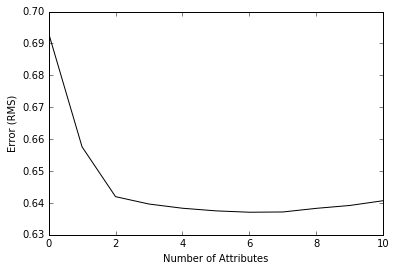

Out of sample error versus attribute set size
[0.69325628904323178, 0.65758597660404394, 0.64196032419017068, 0.63964558060903787, 0.63832972379983288, 0.63750548593395262, 0.63707686266242047, 0.63716204329110915, 0.63829914257011333, 0.63920181983599822, 0.64069848560758336]

Best attribute indices
[10, 9, 1, 8, 4, 6, 5, 2, 7, 0, 3]

Best attribute names
['alcohol (10)', 'sulphates (9)', 'volatile acidity (1)', 'pH (8)', 'chlorides (4)', 'total sulfur dioxide (6)', 'free sulfur dioxide (5)', 'citric acid (2)', 'density (7)', 'fixed acidity (0)', 'residual sugar (3)']

Rmse Results of Forward Stepwise Regression


,alcohol (10),sulphates (9),volatile acidity (1),pH (8),chlorides (4),total sulfur dioxide (6),free sulfur dioxide (5),citric acid (2),density (7),fixed acidity (0),residual sugar (3)
RMSE,0.693256,0.657586,0.64196,0.639646,0.63833,0.637505,0.637077,0.637162,0.638299,0.639202,0.640698


In [16]:
#index list positions 
index_positions = range(len(x_list))
x_list_ = [x_list[i] for i in index_positions]
y_ = [labels[i] for i in index_positions]

#try each feature to see which one gives least oos error
stepwise_indices = []
indx = range(len(x_list_[1]))
index_set = set(indx)
oos_error = []
for i in indx:
    feature_set = set(stepwise_indices)
    try_set = index_set - feature_set
    try_list = [i for i in try_set]  
    error_list, temp_list = [], []
    for feat in try_list:  
        temp_list = [] + stepwise_indices
        temp_list.append(feat)
        xTemp = x_features_cols(x_list_, temp_list) #add next feature to dataset
        x_ = np.array(xTemp); y_ = np.array(y_)  #convert to numpy arrays
        modl = LinearRegression()  
        modl.fit(x_, y_)
        step_preds = cross_val_predict(modl, x_, y_, cv=10) #make predictions
        rms_error = calc_rmse(step_preds, y_)  #calculate errors
        error_list.append(rms_error)
        temp_list = []
    iBest = np.argmin(error_list)
    stepwise_indices.append(try_list[iBest])
    oos_error.append(error_list[iBest])
    
#plot error versus number of attributes
xaxis = range(len(oos_error))
plt.plot(xaxis, oos_error, 'k')
plt.xlabel('Number of Attributes')
plt.ylabel('Error (RMS)')
plt.show()

print('Out of sample error versus attribute set size')
print(oos_error)
print('\nBest attribute indices')
print(stepwise_indices)
stepwise_sequence = [df.columns[i] for i in stepwise_indices]
print('\nBest attribute names')
print(stepwise_sequence)
oos_rounded = []
for i in oos_error:
    oos_rounded.append(round(i,7))
df_features = pd.DataFrame(zip(oos_rounded), index = stepwise_sequence, columns = ['RMSE'])
print '\nRmse Results of Forward Stepwise Regression'
df_features.T

#### 2. Stepwise Regression 6 features

In [17]:
def run_stepwise_2(x, y):
    modl = LinearRegression()
    modl.fit(x, y)
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Stepwise Regression', preds, modl.coef_, modl.intercept_, 
                  stepwise_sequence[0:6], y)

#### 3. Gradient Descent 6 features, from scratch, x scaled 

In [18]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = zip(x, y)
    theta = theta_0   # theta-initial guess
    alpha = alpha_0   # alpha-initial step size
    min_theta = None  # the minimum so far
    min_value = float("inf") 
    iterations_with_no_improvement = 0
    while iterations_with_no_improvement < 100: 
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)
        # if we've found a new minimum, remember it & go back to the original step size
        if value < min_value: 
            min_theta = theta
            min_value = value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:  # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
        for x_i, y_i in in_random_order(data):
            # and take a gradient step for each of the data points
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = np.subtract(theta, np.multiply(alpha, gradient_i)) 
    return min_theta

def sqd_err_gradient(x_i, y_i, beta):  
    return [-2 * x_ij * regr_error(x_i, y_i, beta) for x_ij in x_i]

def sqd_err_regr(x_i, y_i, beta):  
    return regr_error(x_i, y_i, beta) ** 2

def estimate_beta_sgd(x, y):  
    beta_initial = [random.random() for x_i in x[0]]
    beta = minimize_stochastic(sqd_err_regr, sqd_err_gradient, x, y, beta_initial, 0.001)
    return beta

def run_gr_des_3(x, y):
    random.seed(0)
    beta = estimate_beta_sgd(x, y)
    preds = calc_pred_vals(x[:,1:], beta[1:], beta[0])
    coefs = beta[1:]
    model_details('Gradient Descent 6 features, from scratch, x scaled', preds, coefs, 
                  beta[0], stepwise_sequence[0:6], y)

#### 4. Gradient Descent 6 features, sklearn, x scaled

In [19]:
def run_gradient_descent_4(x, y):
    modl = SGDRegressor(penalty='none', random_state=0)
    modl.fit(x, y) 
    preds = cross_val_predict(modl, x, y, cv=10) #make predictions
    model_details('Gradient Descent 6 features, sklearn, x scaled', preds, modl.coef_, 
                  modl.intercept_, stepwise_sequence[0:6], y)

#### Running Models

In [20]:
# create lists for storing details
modl_name = [] # name for model
rmse = [] # root mean square error
accuracy = [] # overall accuracy
cmats = [] # confusion matrix dataframe
cmat_sum = [] # to confirm no results are missing
df_beta_coefs = [] # coefficients dataframe

In [21]:
# results of Stepwise Algorithm #1 appear in prior section
run_stepwise_2(df[stepwise_sequence[0:6]], df['target'])

In [23]:
import random
run_gr_des_3(sm.add_constant(np.array(df_scaled[stepwise_sequence[0:6]]).tolist()), labels)

In [24]:
run_gradient_descent_4(df_scaled[stepwise_sequence[0:6]], df['target'])

#### Model Scores

In [25]:
df_scores = pd.DataFrame(zip(rmse, accuracy), columns = ['RMSE', 'Overall Accuracy'], 
                         index = modl_name)
df_scores

,RMSE,Overall Accuracy
Stepwise Regression,0.637505,0.590782
"Gradient Descent 6 features, from scratch, x scaled",0.631025,0.597067
"Gradient Descent 6 features, sklearn, x scaled",0.638019,0.593575


Confirm all confusion matrix entries were picked up

In [26]:
cmat_sum

[1432, 1432, 1432]

#### Model Summaries

In [27]:
print 'RMSE', rmse[0]
df_beta_coefs[0]

RMSE 0.637505485934


,intercept,alcohol (10),sulphates (9),volatile acidity (1),pH (8),chlorides (4),total sulfur dioxide (6)
Stepwise Regression,3.97424,0.2938,1.5741,-0.74181,-0.53087,-1.7677,-0.00202


In [28]:
print 'RMSE', rmse[1]
df_beta_coefs[1]

RMSE 0.631025318879


,intercept,alcohol (10),sulphates (9),volatile acidity (1),pH (8),chlorides (4),total sulfur dioxide (6)
"Gradient Descent 6 features, from scratch, x scaled",5.65703,0.29709,0.18928,-0.12342,-0.07216,-0.04934,-0.05409


In [29]:
print 'RMSE', rmse[2]
df_beta_coefs[2]

RMSE 0.638018625131


,intercept,alcohol (10),sulphates (9),volatile acidity (1),pH (8),chlorides (4),total sulfur dioxide (6)
"Gradient Descent 6 features, sklearn, x scaled",5.6497,0.29547,0.18785,-0.12598,-0.07475,-0.05383,-0.04987


#### Confusion Matrices & Overall Accuracy

In [30]:
print modl_name[0]
print 'overall accuracy:', accuracy[0]
cmats[0]

Stepwise Regression
overall accuracy: 0.590782122905


,P3,P4,P5,P6,P7,P8,Total
A3,0,0,6,1,0,0,7
A4,0,0,27,16,0,0,43
A5,0,0,409,180,2,0,591
A6,0,0,179,398,21,0,598
A7,0,0,6,134,39,0,179
A8,0,0,0,8,6,0,14


In [31]:
print modl_name[1]
print 'overall accuracy:', accuracy[1]
cmats[1]

Gradient Descent 6 features, from scratch, x scaled
overall accuracy: 0.597067039106


,P3,P4,P5,P6,P7,P8,Total
A3,0,0,6,1,0,0,7
A4,0,0,28,15,0,0,43
A5,0,0,413,176,2,0,591
A6,0,0,178,398,22,0,598
A7,0,0,6,129,44,0,179
A8,0,0,0,8,6,0,14


In [33]:
print modl_name[2]
print 'overall accuracy:', accuracy[2]
cmats[2]

 Gradient Descent 6 features, sklearn, x scaled
overall accuracy: 0.593575418994


,P3,P4,P5,P6,P7,P8,Total
A3,0,0,6,1,0,0,7
A4,0,0,27,16,0,0,43
A5,0,0,410,179,2,0,591
A6,0,0,175,402,21,0,598
A7,0,0,6,135,38,0,179
A8,0,0,0,8,6,0,14
